# Project 2: Denoising Neural Network for Fashion MNIST Dataset

---

## Introduction
This report has been divided into three parts, each of which being subdivided into the seven steps of the design methodology we follow.

* **1. Goals**
* **2. Model and architecture of the Network**
* **3. Data preparation**
* **4. Training procedures**
* **5. Test and performance evaluations**
* **6. Results, observations and conclusions**
* **7. Full code**

## 1. Goals
The aim of this project is to implement and train a Denoising Convolutional Autoencoder Network for image reconstruction, and to test it and analyze the results. We will use the Fashion MNIST image dataset and manually add noise to the images.

By giving noisy images as inputs to the Autoencoder NN, the encoder part will compress them, and the decoder will reconstruct the original denoised images from the compressed representation. Finally, we will see how well the model performs after training by giving it some test images for denoising and reconstruction.

## 2. Model and architecture of the Network
The Autoencoder NN is divided into an encoder part and a symmetric decoder part.
* **Encoder layers**
  * *Convolutional layer 1*: input channels = 1 (grayscale image), output channels = 64 (number of kernels), kernel size = 3, padding = 1; 
  * *Convolutional layer 2*: input channels = 64, output channels = 32, kernel size = 3, padding = 1;
  * *Convolutional layer 3*: input channels = 32, output channels = 16, kernel size = 3, padding = 1;
  * *Convolutional layer 4*: input channels = 16, output channels = 8, kernel size = 3, padding = 1;
  * *Max Pooling layer*: size = 2x2;
* **Decoder layers**
  * *Transposed Convolutional layer 1*:  input channels = 8, output channels = 8, kernel size = 3, stride = 2;
  * *Transposed Convolutional layer 2*:  input channels = 8, output channels = 16, kernel size = 3, stride = 2;
  * *Transposed Convolutional layer 3*:  input channels = 16, output channels = 32, kernel size = 2, stride = 2;
  * *Transposed Convolutional layer 4*:  input channels = 32, output channels = 64, kernel size = 2, stride = 2;
  * *Convolutional layer (output)*:  input channels = 64, output channels = 1, kernel size = 3, padding = 1.

Each of the encoding layers is passed through the ReLU activation function, and there is a max pooling layer after each convolutional layer. After the last pooling layer we get the latent space code representation of the input data.

Similarly, every transposed convolutional layer is passed through the ReLU function, and the final convolutional layer uses the sigmoid activation function.

![Trained CNN Architecture](https://drive.google.com/uc?id=1cqMWn13qhPi5Cb3eMiXeJhyedJR460Pa)



## 3. Data preparation

### Imports and costants

First, we import all the useful modules.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

Then, we define some useful constants. We will train the network for 8 epochs, with a learning rate of 0.001 and a batch size of 16. The `NOISE_FACTOR` defines the amount of noise we will add to the images.

We will use the GPU for the computation if available, otherwise the CPU will be used.

In [ ]:
# constants
NUM_EPOCHS = 8
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
NOISE_FACTOR = 0.1

# if available use GPU, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the data

We prepare the training set and test set.

In [ ]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(), # converting image pixel data to tensors
    transforms.Normalize((0.5,), (0.5,)), # normalizing in the range [0,1]
])

# load
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

# check training set and test set size
print("Training set size:", len(train_set)) # 60000
print("Test set size:", len(test_set)) # 10000

Training set size: 60000
Test set size: 10000


### Visualize training data

Let's visualize 20 random images from the training set, with their respective label.

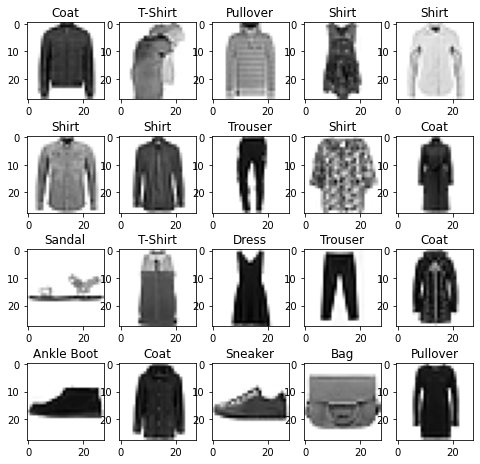

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.show()

## 4. Training procedures

### Define the autoencoder NN architecture

We define all the layers we will require in the `Autoencoder` class constructor, and build the neural network in the `forward()` function.

We istantiate a `model` object and print it to see the architecture.

In [ ]:
# the autoencoder network
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoding
        x = torch.nn.functional.relu(self.enc1(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.enc2(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.enc3(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.enc4(x))
        x = self.pool(x) # latent space representation
        
        # decoding
        x = torch.nn.functional.relu(self.dec1(x))
        x = torch.nn.functional.relu(self.dec2(x))
        x = torch.nn.functional.relu(self.dec3(x))
        x = torch.nn.functional.relu(self.dec4(x))
        x = torch.nn.functional.sigmoid(self.out(x))

        return x

# create a model
model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Training

We will write the training function. First, we define the loss function, in our case the Mean Squared Error, and the optimization algorithm, Adam.

The training function loops over the epochs and batch by batch. It returns the training loss data.

In [ ]:
# the loss function
error = nn.MSELoss()
# the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# the training function
def train(model, train_loader, NUM_EPOCHS):
    train_loss = []
    iteration = 0

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data # we do not need the image labels

            # add noise to the image data
            img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)

            # clip to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)

            # load the noisy images to the computation device 
            img_noisy = img_noisy.to(device)

            # set the gradients to zero
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(img_noisy)
            loss = error(outputs, img_noisy)

            # backpropagation
            loss.backward()

            # update the parameters
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

    return train_loss

We call the `train` function and execute the training process.

In [ ]:
model.to(device)

train_loss = train(model, train_loader, NUM_EPOCHS)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 of 8, Train Loss: 0.0334
Epoch 2 of 8, Train Loss: 0.0264
Epoch 3 of 8, Train Loss: 0.0252
Epoch 4 of 8, Train Loss: 0.0245
Epoch 5 of 8, Train Loss: 0.0241
Epoch 6 of 8, Train Loss: 0.0237
Epoch 7 of 8, Train Loss: 0.0235
Epoch 8 of 8, Train Loss: 0.0233


## 5. Test and performance evaluations

### Loss curve

We plot the training loss data over the epochs.

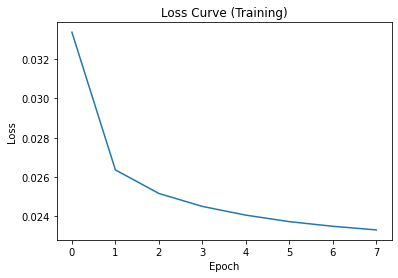

In [ ]:
# loss curve
plt.figure()
plt.plot(train_loss)
plt.title('Loss Curve (Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Image reconstruction

We define a new function, `test_image_reconstruction`, that adds noise to images never given as inputs to the network, and performs the image reconstructions for just one batch.

It also visualizes 5 noisy images and their reconstructions.

In [ ]:
def test_image_reconstruction(model, test_loader):
    for batch in test_loader:
        img, _ = batch
        # add noise to the images
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)
        outputs = model(img_noisy)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        break

    # visualize noisy and reconstructed images
    img_noisy = img_noisy.cpu().data
    figure = plt.figure(figsize=(10, 5))
    cols, rows = 5, 2
    for i in range(cols):
        # noisy images
        figure.add_subplot(rows, cols, i+1)
        img_noisy_show = img_noisy[i, :, :, :].permute(1, 2, 0) 
        plt.title("noisy")
        plt.imshow(np.squeeze(img_noisy_show), cmap="gray_r")
        # reconstructed images
        figure.add_subplot(rows, cols, i+cols+1)
        outputs_show = outputs[i, :, :, :].permute(1, 2, 0)
        plt.title("reconstructed") 
        plt.imshow(np.squeeze(outputs_show), cmap="gray_r")
    plt.show()

Let's call the test function, print the images, and save the trained network to file.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


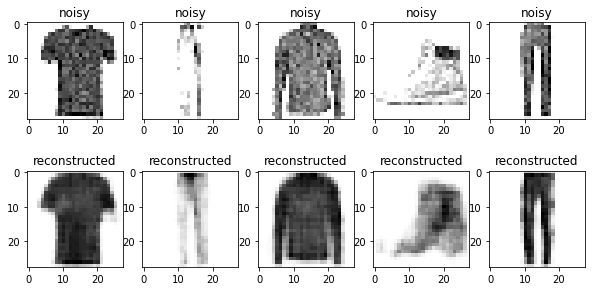

In [ ]:
test_image_reconstruction(model, test_loader)

torch.save(model.state_dict(), "saved_denoisingCNN.pth")

## 6. Results and conclusions



## 7. Code


---
## Bibliography

1. [Netron](https://netron.app/) - Visualizer for neural network, deep learning, and machine learning models.

2. [Autoencoder Neural Network: Application to Image Denoising](https://debuggercafe.com/autoencoder-neural-network-application-to-image-denoising/)